In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords

#sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["user", "time", "text", "label"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 12
BATCH_SIZE = 1024

### Read Dataset

In [4]:
df = pd.read_csv('D:/NLP/Dataset/2_tj_stage2.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
print("Dataset size:", len(df))

Dataset size: 10649


In [6]:
df.head(5)

,user,time,text,label
0,sianturi_enjoy,9/30/2017 4:46,tolong doong koridor b12 trayek jangan pendek ...,2
1,aldialga,9/29/2017 23:43,oke terima kasih min,1
2,must_sigit,9/29/2017 23:34,mantap jaya,1
3,dy518,9/29/2017 22:31,hrus kondisi tugas dimonas ragunannya perhatik...,3
4,dy518,9/29/2017 22:30,lama banget hari padahal semanggi tidak macet2...,2


In [7]:
encoder = LabelEncoder()
df['labelEncoded'] = encoder.fit_transform(df['label'])

In [8]:
df.label = df['labelEncoded']

Text(0.5, 1.0, 'Dataset labels distribuition')

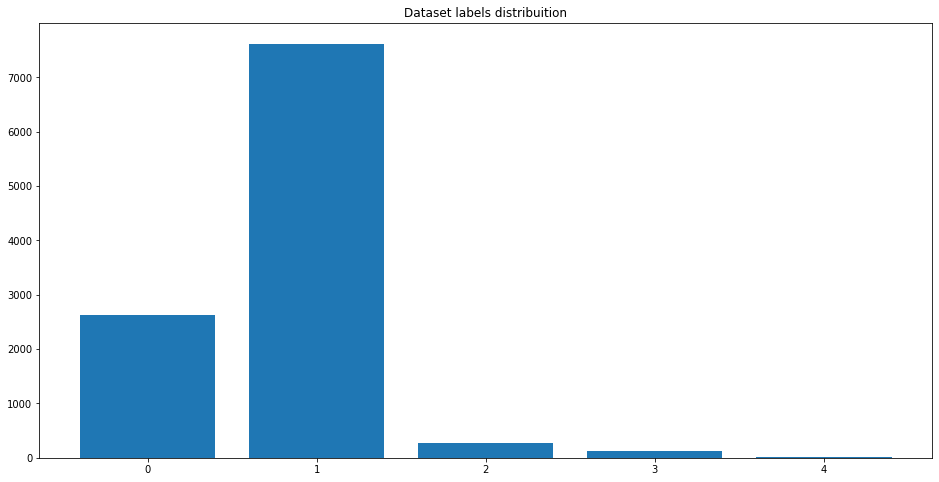

In [9]:
label_cnt = Counter(df.label)

plt.figure(figsize=(16,8))
plt.bar(label_cnt.keys(), label_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [10]:
stop_words = stopwords.words("indonesian")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 1.11 s
Wall time: 1.11 s


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=0)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 9584
TEST size: 1065


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 15.6 ms
Wall time: 18 ms


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-07-10 22:50:11,643 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-07-10T22:50:11.643201', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [16]:
w2v_model.build_vocab(documents)

2022-07-10 22:50:11,658 : INFO : collecting all words and their counts
2022-07-10 22:50:11,659 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-10 22:50:11,689 : INFO : collected 9823 word types from a corpus of 81892 raw words and 9584 sentences
2022-07-10 22:50:11,690 : INFO : Creating a fresh vocabulary
2022-07-10 22:50:11,704 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 1087 unique words (11.07% of original 9823, drops 8736)', 'datetime': '2022-07-10T22:50:11.704203', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
2022-07-10 22:50:11,705 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 64991 word corpus (79.36% of original 81892, drops 16901)', 'datetime': '2022-07-10T22:50:11.705203', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15

In [17]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1087


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-07-10 22:50:11,787 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 1087 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-07-10T22:50:11.787212', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
2022-07-10 22:50:11,884 : INFO : EPOCH 0: training on 81892 raw words (48202 effective words) took 0.1s, 733847 effective words/s
2022-07-10 22:50:11,966 : INFO : EPOCH 1: training on 81892 raw words (48217 effective words) took 0.1s, 789269 effective words/s
2022-07-10 22:50:12,051 : INFO : EPOCH 2: training on 81892 raw words (48236 effective words) took 0.1s, 754396 effective words/s
2022-07-10 22:50:12,141 : INFO : EPOCH 3: training on 81892 raw words (48322 effective words) took 0.1s, 692289 effective words/s
2022-07-10 22:50:12,224 : INFO : EPOCH 4: training on 81892 r

CPU times: total: 6.78 s
Wall time: 2.67 s


(1544470, 2620544)

In [19]:
w2v_model.wv.most_similar("bagus")

[('jelek', 0.7660567164421082),
 ('acara', 0.7414588928222656),
 ('gubernur', 0.7409918904304504),
 ('keren', 0.7199463844299316),
 ('so', 0.7188284397125244),
 ('hbd', 0.7063980102539062),
 ('dengar', 0.7011215686798096),
 ('scania', 0.6897645592689514),
 ('vintage', 0.6867256164550781),
 ('smoga', 0.6687206029891968)]

### Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 9824
CPU times: total: 172 ms
Wall time: 167 ms


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 188 ms
Wall time: 193 ms


### Label Encoder 

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (9584, 1)
y_test (1065, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (9584, 300)
y_train (9584, 1)

x_test (1065, 300)
y_test (1065, 1)


In [24]:
y_train[:10]

array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

### Embedding layer

In [25]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(9824, 300)


In [26]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [27]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          2947200   
                                                                 
 conv1d (Conv1D)             (None, 300, 128)          153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 75, 32)            8

### Compile model

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [29]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [30]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/12
9/9 [==============================] - 36s 4s/step - loss: 0.4014 - accuracy: 0.6937 - val_loss: 0.1084 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 2/12
9/9 [==============================] - 36s 4s/step - loss: -0.0881 - accuracy: 0.8041 - val_loss: -0.7349 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 3/12
9/9 [==============================] - 37s 4s/step - loss: -2.2413 - accuracy: 0.8685 - val_loss: -5.2926 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 4/12
9/9 [==============================] - 37s 4s/step - loss: -13.7283 - accuracy: 0.8647 - val_loss: -28.9505 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 5/12
9/9 [==============================] - 38s 4s/step - loss: -66.9345 - accuracy: 0.8604 - val_loss: -109.3169 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 6/12
9/9 [==============================] - 38s 4s/step - loss: -214.2782 - accuracy: 0.8546 - val_loss: -342.1463 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 7/12
9/9 [==============================] - 37s 4s/step - loss: -668.

### Evaluate

In [31]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 2s 75ms/step - loss: -1180.0186 - accuracy: 0.8516

ACCURACY: 0.8516432046890259
LOSS: -1180.0185546875
CPU times: total: 5.95 s
Wall time: 1.75 s


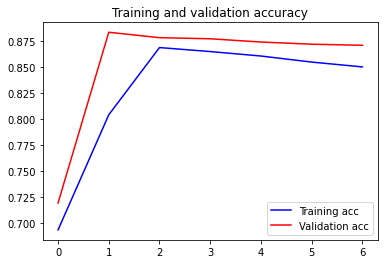

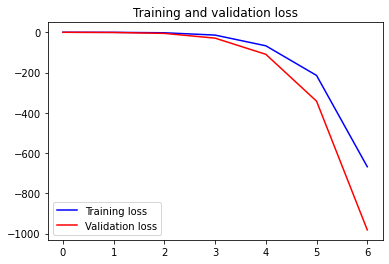

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Confusion Matrix

In [33]:
import seaborn as sns

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Happy','Angry','Sad','Fear','Suprised']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

34/34 [==============================] - 2s 53ms/step


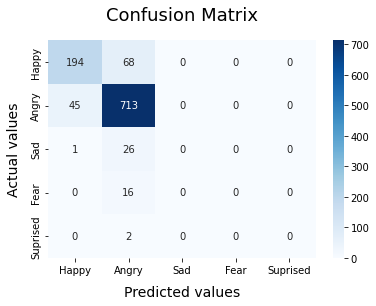

In [34]:
# Predicting on the Test dataset.
y_pred = model.predict(x_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

### Classification Report

In [35]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8083    0.7405    0.7729       262
           1     0.8642    0.9406    0.9008       758
           2     0.0000    0.0000    0.0000        27
           3     0.0000    0.0000    0.0000        16
           4     0.0000    0.0000    0.0000         2

    accuracy                         0.8516      1065
   macro avg     0.3345    0.3362    0.3347      1065
weighted avg     0.8140    0.8516    0.8313      1065



C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Accuracy Score

In [36]:
accuracy_score(y_test, y_pred)

0.8516431924882629

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)